# Leveraging Distributed Representations of Extracted Knowledge for Machine Learning of Plausible Drug Side-Effects
## AMIA 2017
Justin Mower, Devika Subramanian, Trevor Cohen

## Introduction

At the github link where this notebook is hosted, there should be a zip file containing all of the necessary data files to regenerate the results of our recent JAMIA paper. Download and unzip the file, and then make sure the file paths are correct in this notebook. It is recommend to use the Anaconda Python distribution to regenerate these results, and an environment meeting all of the required packages can be created from the environment.yml file. 

## Data Sets
#### EU-ADR

The EU-ADR reference standard is comprised of 43 positive and 50 negative controls (93 combined) across 10 ADEs. Mitral valve disorders *only* have negative control examples in the reference set, but all other ADEs are represented by both. All drugs (except for nimesulide) and ADEs in the set have representations in the vector space utilized. The 10 ADEs are, written as queried in the vector space: 
1. **anaphylaxis**
2. **aplastic\_anemia**
3. **erythema\_multiforme**
4. **diseases\_of\_mitral\_valve**
5. **neutropenia**
6. **rhabdomyolysis**
7. **acute\_myocardial\_infarction**
8. **gastrointestinal\_hemorrhage**
9. **acute_kidney_insufficiency**
10. **liver\_failure,\_acute**

The startlist used with VectorStoreSubset is in startlists/euadrquery.txt. Labels corresponding to these queries are found in startlists/euadrreflabsandqueries.txt. The labels, order-matched to euadrquery.txt, is found in startlists/euadrlabels.txt. Binary vector output from VectorStoreSubset is found in subsetvecs/binary/euadrquery_subset.bin and subsetvecs/binary/psieuadr_subset.bin. The plaintext vectors are found in subsetvecs/text/euadrquery_subset.txt. The ordering is different between the euadrquery_subset.txt and the euadrquery.txt, so a dictionary generated from the euadrreflabsandqueries.txt to translate the new order with the appropriate labels was utilized.

#### OMOP (Ryan et al)

The OMOP reference standard published by Ryan et al is comprised of 165 positive and 234 negative controls (399 combined) across 4 ADEs. The 4 ADEs are, written here as they were queried in the vector space:
1. **acute\_myocardial\_infarction**
2. **gastrointestinal\_hemorrhage**
3. **acute\_kidney\_insufficiency**
4. **liver\_failure,\_acute**

Not all drugs are accounted for in the vector space. Specifically, darunavir (aka Prezista;Prezcobix) and sitagliptin (aka Januvia) have no representation in the vector space, or in the translated names I could find for them. Niacin was translated to nicotinic_acid. All other drugs were queried as-is in the reference standard supplementary material excel spreadsheet presented with the OMOP reference standard paper.

As with the EU-ADR reference set, the startlist used with VectorStoreSubset is in startlists/OMOPquery.txt. Labels corresponding to these queries are found in startlists/OMOPlabsandqueries.txt. The labels, order-matched to OMOPquery.txt, is found in startlists/OMOPlabels.txt. Binary vector output from VectorStoreSubset is found in subsetvecs/binary/OMOPquery_subset.bin and subsetvecs/binary/psiomop_subset.bin. The plaintext vectors are found in subsetvecs/text/OMOPquery_subset.txt. The ordering is different between the OMOPquery_subset.txt and the OMOPquery.txt, so a dictionary generated from the OMOPreflabsandqueries.txt to translate the new order with the appropriate labels was utilized.

#### SIDER Derived

For the SIDER derived vectors, the full set of drugs was downloaded and put into composed query form with the four side-effects from OMOP (startlists/raw[ADE]siderquery.txt). For drugs that didn't have representation in the space, they were removed from the list (startlists/[ADE]siderquery.txt). Then, drugs that were in the OMOP reference standard were removed (noOMOP[ADE]siderquery.txt) and then high performance set MEDI indications were removed (noOMOPnoMEDI[ADE]sider.txt). These individual ADE lists were concatenated into startlists/noOMOPnoMEDIfullsider.txt). The MEDI indications from the high performance set can be found in startlists/medihpsindications.txt. This resulted in variable length lists for each side-effect, which their startlist can be found in startlists/noOMOPnoMEDIfullsider.txt. There is no corresponding label file for these, as ground-truth for our analysis isn't known. The binary vector output is from VectorStoreSubset is found in subsetvecs/binary/noOMOPnoMEDIfullsider_subset.bin. The plaintext vectors are found in subsetvecs/text/noOMOPnoMEDIfullsider_subset.txt.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
from  bitarray import bitarray
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
output_notebook() #for bokeh to work

Loading BokehJS ...

In [2]:
#Define some useful functions

# Load Data from Raw Text
# Expects QUERY|BINARYVECTOR; label file LABEL\tQuery
# Returns a df with Query, Label, Vectors
def loaddata(inputfile, labelfile):
    tmpvecs = []
    tmpqueries = []
    with open(inputfile, 'r') as infile:
        infile.readline()#skip header row
        for line in infile:
            tmp = line.strip().split('|')
            tmpvecs += [np.asarray(bitarray(tmp[1]), dtype=int)]
            tmpqueries += [tmp[0]]
        tmpdf = pd.DataFrame(np.asarray(tmpvecs))
        tmpdf.columns = [str(x) for x in range(1, np.asarray(tmpvecs).shape[1]+1)]
        tmpdf.insert(0, 'Query', tmpqueries)
    labsdict = dict()
    with open(labelfile,'r') as infile:
        for line in infile:
            tmp = line.strip().split('\t')
            labsdict[tmp[1]] = int(tmp[0])
    tmpdf.insert(1, 'Label', [labsdict[x] for x in tmpqueries])
    return tmpdf


# Leave one out crossvalidation quick test
def lootest(df):
    preds = []
    predprob = []
    reals = []
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in LeaveOneOut().split(vecs):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        preds += [model.predict(vecs[test])]
        predprob += [model.predict_proba(vecs[test])[:,1]]
        reals += [labels[test]]
    return(f1_score(reals, preds), roc_auc_score(reals, predprob))
    
# Stratified 5 Fold crossvalidation quick test
# Returns overall F1 and ROC AUC for comparison to other research
# That is, we don't compute fold to fold, but over the whole set
def skftest(df):
    reals = np.asarray([])
    preds = np.asarray([])
    predprob = np.asarray([])
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in StratifiedKFold(n_splits=5, shuffle=True).split(vecs, labels):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        predprob = np.append(predprob, model.predict_proba(vecs[test])[:,1])
        reals = np.append(reals, labels[test])
        preds = np.append(preds, model.predict(vecs[test]))
    return(f1_score(reals, preds), roc_auc_score(reals, predprob))

# kNN leave one out cross-validation quick test
def looknntest(df, neighbors):
    preds = []
    predprob = []
    reals = []
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in LeaveOneOut().split(vecs):
        model = KNeighborsClassifier(n_neighbors=neighbors)
        model.fit(vecs[train], labels[train])
        preds += [model.predict(vecs[test])]
        predprob += [model.predict_proba(vecs[test])[:,1]]
        reals += [labels[test]]
    return(f1_score(reals, preds), roc_auc_score(reals, predprob))

# kNN stratified 5 Fold cross-validation quick test
# Returns overall F1 and ROC AUC for comparison to other research
# That is, we don't compute fold to fold, but over the whole set
def skfknntest(df, neighbors):
    reals = np.asarray([])
    preds = np.asarray([])
    predprob = np.asarray([])
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in StratifiedKFold(n_splits=5, shuffle=True).split(vecs, labels):
        model = KNeighborsClassifier(n_neighbors=neighbors)
        model.fit(vecs[train], labels[train])
        predprob = np.append(predprob, model.predict_proba(vecs[test])[:,1])
        reals = np.append(reals, labels[test])
        preds = np.append(preds, model.predict(vecs[test]))
    return(f1_score(reals, preds), roc_auc_score(reals, predprob))

# Get the average performance across 100 runs for a given LR training model
def get_average_performance(df, trainfunc):
    aucscores = []
    fscores = []
    for i in range(100):
        tmpf1, tmpauc = trainfunc(df)
        fscores += [tmpf1]
        aucscores += [tmpauc]
    return(np.average(fscores), 2*np.std(fscores), np.average(aucscores), 2*np.std(aucscores))

# Get the average performance across 100 runs for a given kNN training model
def get_average_knn_performance(df, trainfunc, neighbors):
    aucscores = []
    fscores = []
    for i in range(100):
        tmpf1, tmpauc = trainfunc(df, neighbors)
        fscores += [tmpf1]
        aucscores += [tmpauc]
    return(np.average(fscores), 2*np.std(fscores), np.average(aucscores), 2*np.std(aucscores))

# Train on | Test on utility
def cross_set_performance(df1, df2):
    fscores = []
    aucscores = []
    for i in range(100): #sort of a bootstrap; captures model instability; takes a while
        lr = LogisticRegression(penalty='l1')
        tmpvecs, tmplabs = shuffle(np.asarray(df1.iloc[:,2:]), np.asarray(df1.Label))
        lr.fit(tmpvecs, tmplabs)
        fscores += [f1_score(df2.Label, lr.predict(df2.iloc[:,2:]))]
        aucscores += [roc_auc_score(df2.Label, lr.predict_proba(df2.iloc[:,2:])[:,1])]
    return(np.average(fscores), 2*np.std(fscores), np.average(aucscores), 2*np.std(aucscores))

# Get tSNE for visualization and put into df
def get_tsne(df, learning_rate=700.0, perplexity=30, locs=[2,2050]):
    tsner = TSNE(learning_rate=learning_rate, perplexity=perplexity, n_iter=5000)
    tsned = tsner.fit_transform(np.asarray(df.iloc[:,locs[0]:locs[1]]))
    visdf = df.iloc[:,:locs[0]]
    visdf.insert(1, 'ADE', [x.split('*')[1] for x in visdf['Query']])
    visdf.insert(1, 'Drug', [x.split('*')[0] for x in visdf['Query']])
    visdf.insert(4, 'tSNEy', tsned[:,1])
    visdf.insert(4, 'tSNEx', tsned[:,0])
    return visdf

In [3]:
# Load ESP Data
omop = loaddata('subsetvecs/text/OMOPquery_subset.txt','startlists/OMOPlabsandqueries.txt')
euadr = loaddata('subsetvecs/text/euadr_subset.txt','startlists/euadrreflabsandqueries.txt')
#EU-ADR has some overlap with OMOP; we'll remove those
euadrnot = euadr[~euadr.Query.isin(omop.Query)]
#And vice versa
omopnot = omop[~omop.Query.isin(euadr.Query)]

#Load PSI Data
psiomop = loaddata('subsetvecs/text/psiomop_subset.txt', 'startlists/OMOPlabsandqueries.txt')
psieuadr = loaddata('subsetvecs/text/psieuadr_subset.txt', 'startlists/euadrreflabsandqueries.txt')
#EU-ADR has some overlap with OMOP; we'll remove those
psieuadrnot = psieuadr[~psieuadr.Query.isin(psiomop.Query)]
#And vice versa
psiomopnot = psiomop[~psiomop.Query.isin(psieuadr.Query)]

In [4]:
# Do a quick LOO and S5F internal test for each reference set
# The variancetest.py script finds the average 100 repetitions (not shown here)
# Variance in LOO in this script is the variance of the models as a result of 
# random initiliazition of starting weights
# LOO scripts require not insignificant computation time (order of hours) so only
# a quick test is done here
# LOO kNN does not have any variance, as the nearest neighbors are constant
# For tests, the overall F1 metric and overall ROC AUC score are computed
# LOO tests here for OMOP will take on the order of 10s of minutes to run, depending on hardware
# LOO tests are commented out just for speed considerations; uncomment if desired


#print("OMOP F1 Score LOO: {:.3f}".format(lootest(omop))) # this will take a while to run
print("OMOP F1 Score S5F: {:.3f} \nOMOP AUC Score S5F: {:.3f}\n".format(*skftest(omop)))
#print("OMOP PSI F1 Score LOO: {:.3f}".format(lootest(psiomop))) # this will take a while to run
print("OMOP PSI F1 Score S5F: {:.3f} \nOMOP PSI AUC Score S5F: {:.3f}\n".format(*skftest(psiomop)))
#print("EUADR F1 Score LOO: {:.3f}".format(lootest(euadr))) # this will take a while to run
print("EUADR F1 Score S5F: {:.3f} \nEUADR AUC Score S5F: {:.3f}\n".format(*skftest(euadr)))
#print("EUADR PSI F1 Score LOO: {:.3f}".format(lootest(psieuadr))) # this will take a while to run
print("EUADR PSI F1 Score S5F: {:.3f} \nEUADR PSI AUC Score S5F: {:.3f}".format(*skftest(psieuadr)))

OMOP F1 Score S5F: 0.920 
OMOP AUC Score S5F: 0.969

OMOP PSI F1 Score S5F: 0.848 
OMOP PSI AUC Score S5F: 0.936

EUADR F1 Score S5F: 0.851 
EUADR AUC Score S5F: 0.926

EUADR PSI F1 Score S5F: 0.462 
EUADR PSI AUC Score S5F: 0.655


In [5]:

# Do a much longer test to capture average performance of models across a variety of conditions.
# This script can be used to regenerate the results in Table 1, simply run the function with the 
# appropriate arguments.
# We do not need to do a variability test for LOO kNN, as the neighbors for LOO are invariant, so the results are 
# always the same
# LOO variation for LR models capture variability in gradient descent and weight parameter initialization
# These runs, especially for LOO, can take on the order of hours to run each one.

print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(*get_average_performance(omop, skftest)))
#print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(*get_average_knn_performance(omop, 
#                                                                                                          skfknntest, 5)))


Average F1: 0.915 +/- 0.016
Average AUC: 0.971 +/- 0.006


In [6]:
# What's the performance like testing on EUADR?
print('Training on OMOP, testing on EUADR (ESP):')
print("F1 Score: {:.3f} +/- {:.3f}\nAUC Score: {:.3f} +/- {:.3f}".format(*cross_set_performance(omop, euadrnot)))
print('Training on OMOP, testing on EUADR (PSI):')
print("F1 Score: {:.3f} +/- {:.3f}\nAUC Score: {:.3f} +/- {:.3f}".format(*cross_set_performance(psiomop, psieuadrnot)))
# What's the performance like testing on OMOP, training EUADR?
print('Training on EUADR, testing on OMOP (ESP):')
print("F1 Score: {:.3f} +/- {:.3f}\nAUC Score: {:.3f} +/- {:.3f}".format(*cross_set_performance(euadr, omopnot)))
print('Training on EUADR, testing on OMOP (PSI):')
print("F1 Score: {:.3f} +/- {:.3f}\nAUC Score: {:.3f} +/- {:.3f}".format(*cross_set_performance(psieuadr, psiomopnot)))

Training on OMOP, testing on EUADR (ESP):
F1 Score: 0.613 +/- 0.000
AUC Score: 0.803 +/- 0.000
Training on OMOP, testing on EUADR (PSI):
F1 Score: 0.098 +/- 0.000
AUC Score: 0.594 +/- 0.000
Training on EUADR, testing on OMOP (ESP):
F1 Score: 0.720 +/- 0.000
AUC Score: 0.828 +/- 0.000
Training on EUADR, testing on OMOP (PSI):
F1 Score: 0.468 +/- 0.000
AUC Score: 0.662 +/- 0.000


In [7]:
# Which ones does it get right (quickly training a single model)? 
# It gets a lot right, including side-effects it hasn't seen before
omoplr = LogisticRegression(penalty='l1')
tmpvecs, tmplabs = shuffle(np.asarray(omop.iloc[:,2:]), np.asarray(omop.Label))
omoplr.fit(tmpvecs, tmplabs)
correctlist = zip(euadrnot['Label'], omoplr.predict(euadrnot.iloc[:,2:]), euadrnot.Query)
print(f'{"Query ":>50} {"Predicted":^9}   {"True":^5}')
counterthing = 1 # I know this is ugly, but it works for keeping the output short
for i in correctlist:
    if counterthing <= 10: # just truncated to ten for brevity
        if i[0] == i[1]:
            print(f"{i[2]:>50} {i[0]:^9}   {i[1]:^5}")
            counterthing += 1

                                            Query  Predicted   True 
                 S(allopurinol)*S(aplastic_anemia)     1         1  
       S(methotrexate)*S(diseases_of_mitral_valve)     0         0  
 S(ferrous_sulfate)*S(acute_myocardial_infarction)     0         0  
                 S(latanoprost)*S(aplastic_anemia)     0         0  
     S(dorzolamide)*S(gastrointestinal_hemorrhage)     0         0  
              S(furosemide)*S(erythema_multiforme)     1         1  
                      S(diclofenac)*S(anaphylaxis)     1         1  
        S(thyroxine)*S(acute_kidney_insufficiency)     0         0  
                     S(timolol)*S(aplastic_anemia)     0         0  
             S(allopurinol)*S(erythema_multiforme)     1         1  


In [8]:
# Which ones does it get wrong (same model as before)? 
# It gets some wrong in side-effects it has seen before
incorrectlist = zip(euadrnot.Label, omoplr.predict(euadrnot.iloc[:,2:]), euadrnot.Query)
print(f'{"Query ":>50} {"Predicted":^9}   {"True":^5}')
counterthing = 1 
for i in incorrectlist:
    if counterthing <= 10: # just truncated to ten for brevity
        if i[0] != i[1]:
            print(f"{i[2]:>50} {i[0]:^9}   {i[1]:^5}")
            counterthing += 1

                                            Query  Predicted   True 
    S(ciprofloxacin)*S(acute_kidney_insufficiency)     1         0  
           S(carbamazepine)*S(erythema_multiforme)     1         0  
                     S(mirtazapine)*S(anaphylaxis)     0         1  
          S(nitroglycerin)*S(liver_failure,_acute)     0         1  
                     S(amoxicillin)*S(anaphylaxis)     1         0  
                 S(fluvastatin)*S(aplastic_anemia)     0         1  
                    S(doxazosin)*S(rhabdomyolysis)     0         1  
S(lithium_carbonate)*S(acute_kidney_insufficiency)     1         0  
             S(lamotrigine)*S(erythema_multiforme)     1         0  
          S(estradiol)*S(diseases_of_mitral_valve)     0         1  


In [9]:
# Get total correct on per ADE basis
predicted = omoplr.predict(euadrnot.iloc[:,2:])
adeperf = {k: [] for k in np.unique([x.split('*')[1] for x in euadrnot.Query])} 
for indx, i in enumerate(euadrnot.Query):
    if predicted[indx] == np.asarray(euadrnot.Label)[indx]:
        adeperf[i.split('*')[1]] += [1]
    else:
        adeperf[i.split('*')[1]] += [0]
for i in adeperf:
    print(f"{i:>30}: {np.average(adeperf[i]):.3f}")

 S(acute_kidney_insufficiency): 0.750
S(acute_myocardial_infarction): 0.778
                S(anaphylaxis): 0.700
            S(aplastic_anemia): 0.600
   S(diseases_of_mitral_valve): 0.400
        S(erythema_multiforme): 0.700
S(gastrointestinal_hemorrhage): 0.875
       S(liver_failure,_acute): 0.429
                S(neutropenia): 0.600
             S(rhabdomyolysis): 0.667


In [10]:
# Let's generate a non-duplicate OMOP + ADIS dataframe
nodups = pd.concat([omop, euadrnot])
psinodups = pd.concat([psiomop, psieuadrnot])

In [11]:
# How do we do with LOO on this? With Stratified 5 Fold?

#print(lootest(nodups)) #this trains 480 models; takes a while, so commented out since S5F is extremely similar perf
print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(*get_average_performance(nodups, skftest)))

# It does very well. In fact, it does better in LOO (usually) than OMOP does
# More importantly perhaps, we do much better than training on OMOP and testing on ADIS.

Average F1: 0.900 +/- 0.018
Average AUC: 0.969 +/- 0.007


In [12]:
#Set up for AUC and AUC graphs
from scipy import interp
from sklearn.metrics import auc, roc_curve

def skfrocauc(vecs, labels):
    aucs = []
    tprs = []
    mean_fpr = np.linspace(0,1,100)
    for train,test in StratifiedKFold(n_splits=5, shuffle=True).split(vecs, labels):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        probas_ = model.predict_proba(vecs[test])[:,1]
        fpr, tpr, thresholds = roc_curve(labels[test], probas_, pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs += [auc(fpr, tpr)]
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_tpr, mean_fpr, mean_auc, aucs

def loorocauc(df):
    tmpdf = df.iloc[:,:2]
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in LeaveOneOut().split(vecs):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        tmpdf.loc[test, 'Prob'] = model.predict_proba(vecs[test])[:,1]
    return tmpdf



In [13]:
omoptpr, omopfpr, omopmeanauc, omopaucs = skfrocauc(np.asarray(omop.iloc[:,2:]), np.asarray(omop.Label))
print(omopmeanauc)
psiomoptpr, psiomopfpr, psiomopmeanauc, psiomopaucs = skfrocauc(np.asarray(psiomop.iloc[:,2:]), np.asarray(psiomop.Label))
print(psiomopmeanauc)

0.966303183349
0.945464110805


In [14]:
# LOO AUC calculations take a while (~30min maybe?), on account of the number of models required to train
loomop = loorocauc(omop) 
psiloomop = loorocauc(psiomop)
loofpr, lootpr, _ = roc_curve(np.asarray(loomop.Label), np.asarray(loomop.Prob), pos_label=1)
psiloofpr, psilootpr, _ = roc_curve(np.asarray(psiloomop.Label), np.asarray(psiloomop.Prob), pos_label=1)

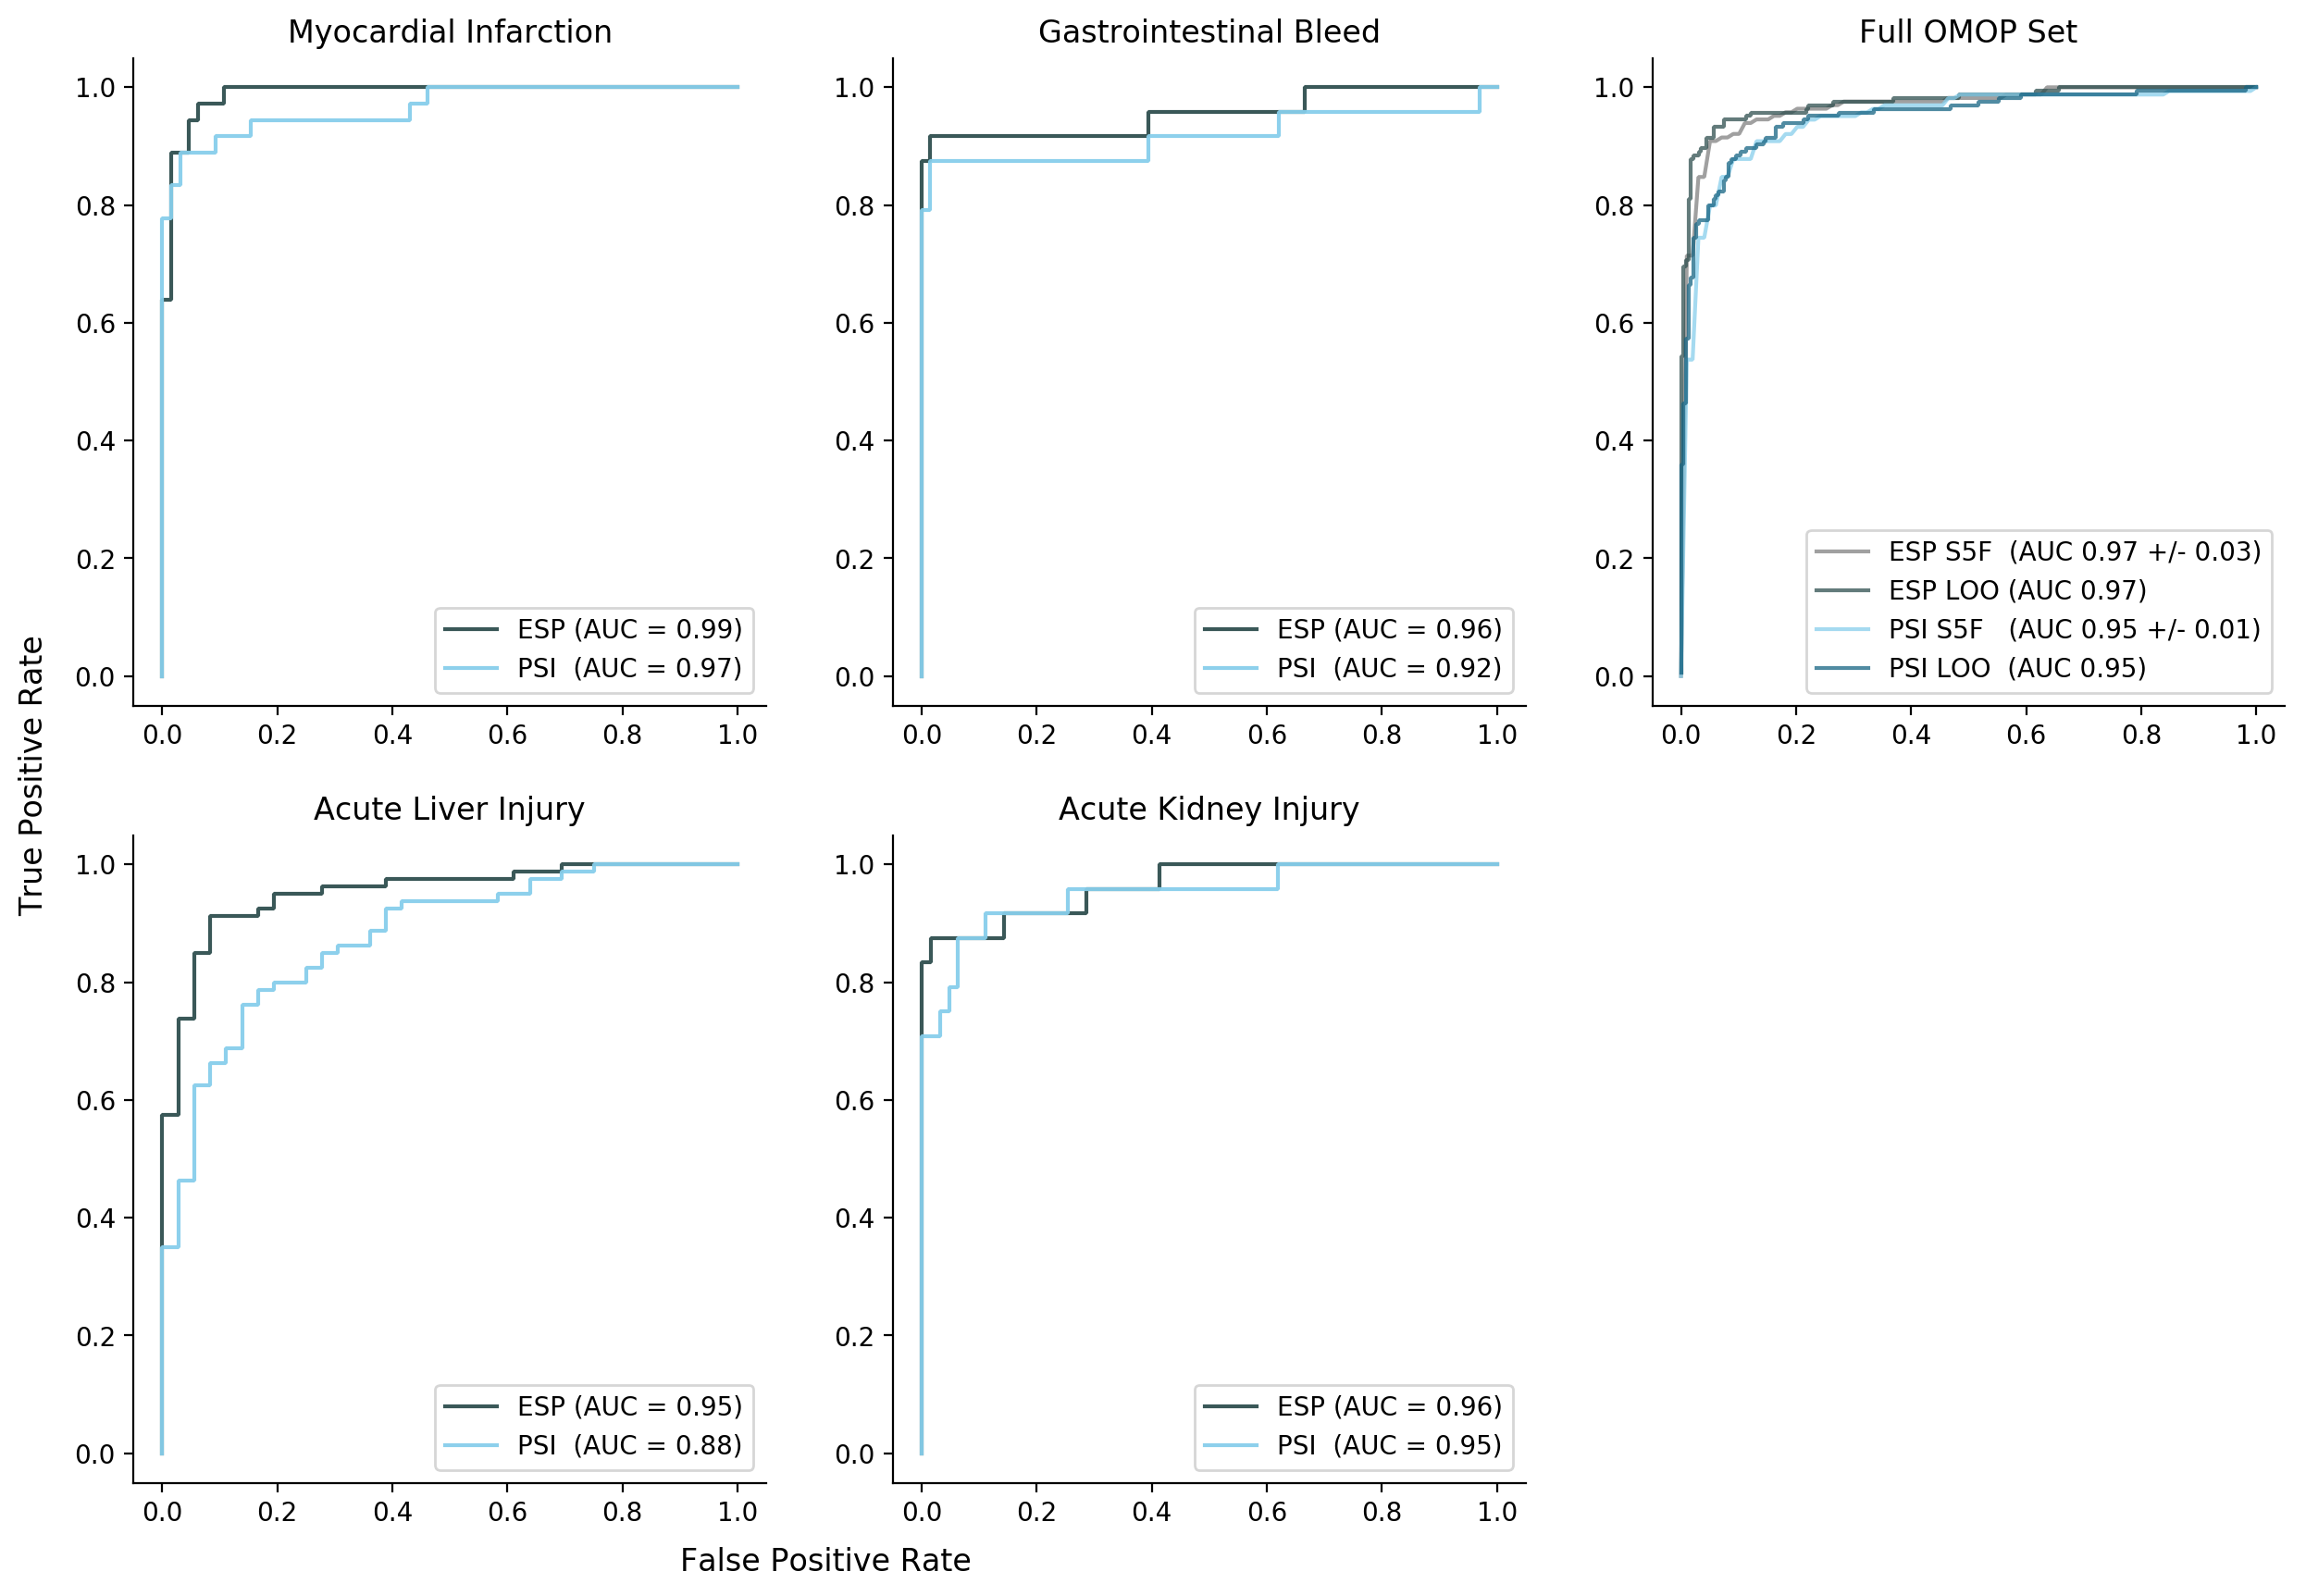

In [15]:
%matplotlib inline
plt.style.use('default')

# Generate per side-effect curves ESP
miloofpr, milootpr, _ = roc_curve(np.asarray(loomop[loomop.Query.str.contains('myocardial')].Label), 
                                  np.asarray(loomop[loomop.Query.str.contains('myocardial')].Prob), 
                                  pos_label=1)
kiloofpr, kilootpr, _ = roc_curve(np.asarray(loomop[loomop.Query.str.contains('kidney')].Label), 
                                  np.asarray(loomop[loomop.Query.str.contains('kidney')].Prob), 
                                  pos_label=1)
giloofpr, gilootpr, _ = roc_curve(np.asarray(loomop[loomop.Query.str.contains('gastrointestinal')].Label), 
                                  np.asarray(loomop[loomop.Query.str.contains('gastrointestinal')].Prob), 
                                  pos_label=1)
liloofpr, lilootpr, _ = roc_curve(np.asarray(loomop[loomop.Query.str.contains('liver')].Label), 
                                  np.asarray(loomop[loomop.Query.str.contains('liver')].Prob), 
                                  pos_label=1)

# Generate per side-effect curves PSI
pmiloofpr, pmilootpr, _ = roc_curve(np.asarray(psiloomop[psiloomop.Query.str.contains('myocardial')].Label), 
                                  np.asarray(psiloomop[psiloomop.Query.str.contains('myocardial')].Prob), 
                                  pos_label=1)
pkiloofpr, pkilootpr, _ = roc_curve(np.asarray(psiloomop[psiloomop.Query.str.contains('kidney')].Label), 
                                  np.asarray(psiloomop[psiloomop.Query.str.contains('kidney')].Prob), 
                                  pos_label=1)
pgiloofpr, pgilootpr, _ = roc_curve(np.asarray(psiloomop[psiloomop.Query.str.contains('gastrointestinal')].Label), 
                                  np.asarray(psiloomop[psiloomop.Query.str.contains('gastrointestinal')].Prob), 
                                  pos_label=1)
pliloofpr, plilootpr, _ = roc_curve(np.asarray(psiloomop[psiloomop.Query.str.contains('liver')].Label), 
                                  np.asarray(psiloomop[psiloomop.Query.str.contains('liver')].Prob), 
                                  pos_label=1)

# Set up 2x2 plot space
plt.figure(1, figsize=(15,10), dpi=200)

def startat0(arr):
    return np.insert(arr, 0, 0.0) #just to make sure that the graph starts at 0,0

#Plot Myocardial Infarction
plt.subplot(231)
plt.subplot(231).spines['top'].set_visible(False)
plt.subplot(231).spines['right'].set_visible(False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot(startat0(miloofpr), startat0(milootpr), label=f'ESP (AUC = {auc(miloofpr, milootpr):3.2f})',
        color='DarkSlateGray', alpha=0.95, solid_joinstyle='bevel')
plt.plot(startat0(pmiloofpr), startat0(pmilootpr), label=f'PSI  (AUC = {auc(pmiloofpr, pmilootpr):3.2f})',
        color='SkyBlue', alpha=0.95, solid_joinstyle='bevel')
plt.yscale('linear')
plt.title('Myocardial Infarction')
plt.legend(loc='lower right')
plt.grid(False)

#Plot GIBleed
plt.subplot(232)
plt.subplot(232).spines['top'].set_visible(False)
plt.subplot(232).spines['right'].set_visible(False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot(startat0(giloofpr), startat0(gilootpr), label=f'ESP (AUC = {auc(giloofpr, gilootpr):3.2f})',
        color='DarkSlateGray', alpha=0.95, solid_joinstyle='bevel')
plt.plot(startat0(pgiloofpr), startat0(pgilootpr), label=f'PSI  (AUC = {auc(pgiloofpr, pgilootpr):3.2f})',
        color='SkyBlue', alpha=0.95, solid_joinstyle='bevel')
plt.yscale('linear')
plt.title('Gastrointestinal Bleed')
plt.legend(loc='lower right')
plt.grid(False)

#Plot Combined Curve
plt.subplot(233)
plt.subplot(233).spines['top'].set_visible(False)
plt.subplot(233).spines['right'].set_visible(False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot(omopfpr, omoptpr, label=f'ESP S5F  (AUC {omopmeanauc:3.2f} +/- {2*np.std(omopaucs):3.2f})',
        color='Gray', alpha=0.75, solid_joinstyle='bevel')
plt.plot(loofpr, lootpr, label=f'ESP LOO (AUC {auc(loofpr, lootpr):3.2f})',
        color='DarkSlateGray', alpha=0.75, solid_joinstyle='bevel')
plt.plot(psiomopfpr, psiomoptpr, label=f'PSI S5F   (AUC {psiomopmeanauc:3.2f} +/- {2*np.std(psiomopaucs):3.2f})',
        color='SkyBlue', alpha=0.75, solid_joinstyle='bevel')
plt.plot(psiloofpr, psilootpr, label=f'PSI LOO  (AUC {auc(psiloofpr, psilootpr):3.2f})',
        color='#166483', alpha=0.75, solid_joinstyle='bevel')
plt.yscale('linear')
plt.title('Full OMOP Set')
plt.legend(loc='lower right')
plt.grid(False)

#Plot Liver Injury
plt.subplot(234)
plt.subplot(234).spines['top'].set_visible(False)
plt.subplot(234).spines['right'].set_visible(False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot(startat0(liloofpr), startat0(lilootpr), label=f'ESP (AUC = {auc(liloofpr, lilootpr):3.2f})',
        color='DarkSlateGray', alpha=0.95, solid_joinstyle='bevel')
plt.plot(startat0(pliloofpr), startat0(plilootpr), label=f'PSI  (AUC = {auc(pliloofpr, plilootpr):3.2f})',
        color='SkyBlue', alpha=0.95, solid_joinstyle='bevel')
plt.yscale('linear')
plt.title('Acute Liver Injury')
plt.legend(loc='lower right')
plt.grid(False)
plt.text(-0.25, 1.35,'True Positive Rate', rotation='vertical', fontsize=12)
plt.text(.9, -0.2,'False Positive Rate', fontsize=12)

#Plot Kidney Injury
plt.subplot(235)
plt.subplot(235).spines['top'].set_visible(False)
plt.subplot(235).spines['right'].set_visible(False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot(startat0(kiloofpr), startat0(kilootpr), label=f'ESP (AUC = {auc(kiloofpr, kilootpr):3.2f})',
        color='DarkSlateGray', alpha=0.95, solid_joinstyle='bevel')
plt.plot(startat0(pkiloofpr), startat0(pkilootpr), label=f'PSI  (AUC = {auc(pkiloofpr, pkilootpr):3.2f})',
        color='SkyBlue', alpha=0.95, solid_joinstyle='bevel')
plt.yscale('linear')
plt.title('Acute Kidney Injury')
plt.grid(False)
plt.legend(loc='lower right')
plt.show()

In [16]:
from bokeh import palettes
nodupsvis = get_tsne(nodups, 200.0, 30, [2, 32000]) # Will likely be some variability in these, but overall consistent trends
adelabs = [''.join([x[0], x[1]]) for x in zip(nodupsvis.ADE, np.asarray(nodupsvis.Label,dtype=str))]
colormap = dict(zip(sorted(list(np.unique(adelabs)) + ['S(diseases_of_mitral_valve)1'], reverse=True), palettes.Category20[20]))
colormap
colors = [colormap[x] for x in adelabs]
nodupsvis.insert(6, 'Color', colors)
nodupsvis.insert(7, 'ADEleg', [x.split(')')[0].split('(')[1].replace('_', ' ').title() for x in nodupsvis.ADE])


In [17]:
from bokeh.models.sources import ColumnDataSource
from bokeh.models.widgets import Panel, Tabs
panels = []
p=figure(title='OMOP + EU-ADR by ADE', plot_width=950, plot_height=600)
for i in np.unique(nodupsvis.ADE):
    p.circle(x='tSNEx', y='tSNEy', source=ColumnDataSource(nodupsvis[nodupsvis.ADE == i]), color='Color', size=10, alpha=0.9, legend='ADEleg')
    tmpfig = figure(title='OMOP + EU-ADR: {}'.format(np.unique(nodupsvis[nodupsvis.ADE==i].ADEleg)[0]), plot_width=950, plot_height=600)
    tmpfig.circle(x='tSNEx', y='tSNEy', source = ColumnDataSource(nodupsvis[nodupsvis.ADE == i]), color='Color', size=10, alpha=0.9, legend='Label')
    tmpfig.add_tools(HoverTool(tooltips=[("Drug", "@Drug"), ("Label", "@Label")]))
    tmpfig.legend.location="top_right"
    tmpfig.legend.click_policy = 'hide'
    tmpfig.grid.visible=False
    tmpfig.xaxis.visible=False
    tmpfig.yaxis.visible=False
    panels += [Panel(child=tmpfig, title='{}'.format(np.unique(nodupsvis[nodupsvis.ADE==i].ADEleg)[0]))]
p.add_tools(HoverTool(tooltips=[("Drug", "@Drug"), ("ADE","@ADE"), ("Label", "@Label")]))
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'
p.grid.visible=False
p.xaxis.visible=False
p.yaxis.visible=False
panels.insert(0, Panel(child=p, title="Full Set"))
tabs = Tabs(tabs=panels)
show(tabs)

In [18]:
def loadsiderdata(inputfile):
    sidervecs = []
    siderqueries = []
    with open(inputfile,'r') as infile:
        infile.readline()
        for line in infile:
            tmp = line.strip().split('|')
            sidervecs += [bitarray(tmp[1])]
            siderqueries += [tmp[0]]
    sidervecs = np.asarray(sidervecs, dtype=int)

    siderdf = pd.DataFrame(sidervecs)
    siderdf.columns = [str(x) for x in range(1,32001)]
    siderdf.insert(0, 'Query', siderqueries)
    return siderdf

In [19]:
def toppreds(trainset, testset):
    regressor = LogisticRegression(C=1, penalty='l1')
    regressor.fit(np.asarray(trainset.iloc[:,2:]), np.asarray(trainset['Label']))
    probs = regressor.predict_proba(np.asarray(testset.iloc[:,1:]))
    return sorted(zip(probs[:,1], np.asarray(testset['Query'])), reverse=True)

In [20]:
sider = loadsiderdata('subsetvecs/text/noOMOPnoMEDIfullsider_subset.txt')
misider = sider[sider.Query.str.contains('myocardial')]
gisider = sider[sider.Query.str.contains('gastro')]
lisider = sider[sider.Query.str.contains('liver')]
kisider = sider[sider.Query.str.contains('kidney')]

In [21]:
# Do we get rofecoxib? Sub drug of choice at leisure
for i in toppreds(omop[omop.Query.str.contains('myocardial')], misider):
    if 'rofecoxib' in i[1]:
        print(i)

(0.9997922942148193, 'S(rofecoxib)*S(acute_myocardial_infarction)')


In [22]:
# Top ten predictions from one model for myocardial infarction?
toppreds(omop, misider)[:10]

[(0.99985831432849781, 'S(naproxen)*S(acute_myocardial_infarction)'),
 (0.99985261620126087, 'S(cilostazol)*S(acute_myocardial_infarction)'),
 (0.99984754091208827, 'S(rofecoxib)*S(acute_myocardial_infarction)'),
 (0.99984718251328608, 'S(perindopril)*S(acute_myocardial_infarction)'),
 (0.99981739786313473, 'S(tenoxicam)*S(acute_myocardial_infarction)'),
 (0.99980930214640984, 'S(valdecoxib)*S(acute_myocardial_infarction)'),
 (0.99979286488605645, 'S(ibuprofen)*S(acute_myocardial_infarction)'),
 (0.99977851520255201, 'S(sertraline)*S(acute_myocardial_infarction)'),
 (0.99971333056891321, 'S(meloxicam)*S(acute_myocardial_infarction)'),
 (0.99970854459773439, 'S(paroxetine)*S(acute_myocardial_infarction)')]

In [23]:
%%capture mioutput
# In order to get a little bit more stability / reproducibility
# we'll look at the things which show up most often in the top 30 for each ADE

tmpdict = dict()
for i in range(1000): # maybe not completely necessary to do 1k iterations
    for thing in toppreds(omop, misider)[:30]:
        try:
            tmpdict[thing[1]] += [thing[0]]
        except KeyError:
            tmpdict[thing[1]] = [thing[0]]
        
for i in tmpdict:
    tmpdict[i] = [np.average(tmpdict[i]), len(tmpdict[i])]

sorted(tmpdict.items(), key=lambda x: x[1], reverse=True)[:20]

In [24]:
mioutput.show()

[('S(naproxen)*S(acute_myocardial_infarction)', [0.99985831432849748, 1000]),
 ('S(cilostazol)*S(acute_myocardial_infarction)', [0.9998526162012612, 1000]),
 ('S(rofecoxib)*S(acute_myocardial_infarction)', [0.99984754091208794, 1000]),
 ('S(perindopril)*S(acute_myocardial_infarction)',
  [0.99984718251328586, 1000]),
 ('S(tenoxicam)*S(acute_myocardial_infarction)', [0.99981739786313473, 1000]),
 ('S(valdecoxib)*S(acute_myocardial_infarction)', [0.99980930214640984, 1000]),
 ('S(ibuprofen)*S(acute_myocardial_infarction)', [0.99979286488605679, 1000]),
 ('S(sertraline)*S(acute_myocardial_infarction)', [0.99977851520255179, 1000]),
 ('S(meloxicam)*S(acute_myocardial_infarction)', [0.99971333056891309, 1000]),
 ('S(paroxetine)*S(acute_myocardial_infarction)', [0.99970854459773417, 1000]),
 ('S(diclofenac)*S(acute_myocardial_infarction)', [0.99967098747527505, 1000]),
 ('S(ticlopidine)*S(acute_myocardial_infarction)',
  [0.99966169874307942, 1000]),
 ('S(fluoxetine)*S(acute_myocardial_infar

In [25]:
%%capture gioutput
# In order to get a little bit more stability / reproducibility
# we'll look at the things which show up most often in the top 30 for each ADE

tmpdict = dict()
for i in range(1000):
    for thing in toppreds(omop, gisider)[:30]:
        try:
            tmpdict[thing[1]] += [thing[0]]
        except KeyError:
            tmpdict[thing[1]] = [thing[0]]
        
for i in tmpdict:
    tmpdict[i] = [np.average(tmpdict[i]), len(tmpdict[i])]

sorted(tmpdict.items(), key=lambda x: x[1], reverse=True)[:20]

In [26]:
gioutput.show()

[('S(tenoxicam)*S(gastrointestinal_hemorrhage)', [0.99989408051059681, 1000]),
 ('S(rofecoxib)*S(gastrointestinal_hemorrhage)', [0.99985849928437187, 1000]),
 ('S(diclofenac)*S(gastrointestinal_hemorrhage)', [0.9997706356876519, 1000]),
 ('S(etoricoxib)*S(gastrointestinal_hemorrhage)', [0.99962318310615061, 1000]),
 ('S(aspirin)*S(gastrointestinal_hemorrhage)', [0.99947831550258204, 1000]),
 ('S(paroxetine)*S(gastrointestinal_hemorrhage)', [0.99890996396835352, 1000]),
 ('S(mefenamic_acid)*S(gastrointestinal_hemorrhage)',
  [0.99758663970387917, 1000]),
 ('S(venlafaxine)*S(gastrointestinal_hemorrhage)', [0.9971380782961814, 1000]),
 ('S(suprofen)*S(gastrointestinal_hemorrhage)', [0.99700561012592137, 1000]),
 ('S(parecoxib)*S(gastrointestinal_hemorrhage)', [0.99637006156146757, 1000]),
 ('S(celecoxib)*S(gastrointestinal_hemorrhage)', [0.99615714793039034, 1000]),
 ('S(ticlopidine)*S(gastrointestinal_hemorrhage)', [0.9944052370777412, 1000]),
 ('S(fluvoxamine)*S(gastrointestinal_hemorrh

In [27]:
%%capture lioutput
# In order to get a little bit more stability / reproducibility
# we'll look at the things which show up most often in the top 30 for each ADE

tmpdict = dict()
for i in range(1000):
    for thing in toppreds(omop, lisider)[:30]:
        try:
            tmpdict[thing[1]] += [thing[0]]
        except KeyError:
            tmpdict[thing[1]] = [thing[0]]
        
for i in tmpdict:
    tmpdict[i] = [np.average(tmpdict[i]), len(tmpdict[i])]

sorted(tmpdict.items(), key=lambda x: x[1], reverse=True)[:20]

In [28]:
lioutput.show()

[('S(aspirin)*S(liver_failure,_acute)', [0.99999869520441309, 1000]),
 ('S(meloxicam)*S(liver_failure,_acute)', [0.99999807803767216, 1000]),
 ('S(rofecoxib)*S(liver_failure,_acute)', [0.9999978562255214, 1000]),
 ('S(pravastatin)*S(liver_failure,_acute)', [0.99999679114981332, 1000]),
 ('S(flurbiprofen)*S(liver_failure,_acute)', [0.99999632503692437, 1000]),
 ('S(nabumetone)*S(liver_failure,_acute)', [0.99999611650868669, 1000]),
 ('S(atorvastatin)*S(liver_failure,_acute)', [0.99999591470858806, 1000]),
 ('S(acyclovir)*S(liver_failure,_acute)', [0.99999566158098785, 1000]),
 ('S(fenoprofen)*S(liver_failure,_acute)', [0.99999533313006062, 1000]),
 ('S(fluvastatin)*S(liver_failure,_acute)', [0.99999525961107938, 1000]),
 ('S(diclofenac)*S(liver_failure,_acute)', [0.9999947560884922, 1000]),
 ('S(rosuvastatin)*S(liver_failure,_acute)', [0.99999398410224349, 1000]),
 ('S(clopidogrel)*S(liver_failure,_acute)', [0.99999343677577279, 1000]),
 ('S(valdecoxib)*S(liver_failure,_acute)', [0.9999

In [29]:
%%capture kioutput
# In order to get a little bit more stability / reproducibility
# we'll look at the things which show up most often in the top 30 for each ADE

tmpdict = dict()
for i in range(1000):
    for thing in toppreds(omop, kisider)[:30]:
        try:
            tmpdict[thing[1]] += [thing[0]]
        except KeyError:
            tmpdict[thing[1]] = [thing[0]]
        
for i in tmpdict:
    tmpdict[i] = [np.average(tmpdict[i]), len(tmpdict[i])]

sorted(tmpdict.items(), key=lambda x: x[1], reverse=True)[:20]

In [30]:
kioutput.show()

[('S(perindopril)*S(acute_kidney_insufficiency)', [0.99996570203572299, 1000]),
 ('S(quinapril)*S(acute_kidney_insufficiency)', [0.99994680751052545, 1000]),
 ('S(ramipril)*S(acute_kidney_insufficiency)', [0.99992943515710131, 1000]),
 ('S(benazepril)*S(acute_kidney_insufficiency)', [0.99992290218058733, 1000]),
 ('S(cilazapril)*S(acute_kidney_insufficiency)', [0.99988101181615141, 1000]),
 ('S(amlodipine)*S(acute_kidney_insufficiency)', [0.99986353180240117, 1000]),
 ('S(trandolapril)*S(acute_kidney_insufficiency)',
  [0.99984626149766076, 1000]),
 ('S(eprosartan)*S(acute_kidney_insufficiency)', [0.99983171613303279, 1000]),
 ('S(valsartan)*S(acute_kidney_insufficiency)', [0.99982688078362203, 1000]),
 ('S(candesartan_cilexetil)*S(acute_kidney_insufficiency)',
  [0.99981475077089865, 1000]),
 ('S(flurbiprofen)*S(acute_kidney_insufficiency)',
  [0.99979315013896131, 1000]),
 ('S(tenoxicam)*S(acute_kidney_insufficiency)', [0.99978964700354378, 1000]),
 ('S(aspirin)*S(acute_kidney_insuff